In [1]:
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d as plt3d
import numpy as np
import os, sys
import matplotlib as mpl
import pandas as pd
import itertools

from astropy import units as u
from astropy.coordinates import Angle

import time
from datetime import datetime,date
import dateutil.parser
import pytz

import argparse

import logging
import coloredlogs
import configparser

from astropy.io import fits

from scipy.stats import rayleigh,beta,gamma,uniform

# Define function to generate simulated atm params according to their prob. distributions 

In [2]:
def simul_params(param,n,a,b,loc,scale):
    ""
    low = loc-scale
    high = loc+scale
    #sim_param = uniform.rvs(loc=loc,scale=scale,size=n)
    sim_param = np.random.uniform(low=low,high=high,size=n)
        
    return sim_param

# Set parameters for simulation 

In [3]:
#Number of simulated parameters of each type 
nsim = 10000
atm_params = ['pwv','aerosol','ozone','cloud','airmass']
dist_params = {'pwv':{'a':3,'b':7,'loc':3.0,'scale':3.0},
               'aerosol':{'a':None,'b':None,'loc':0.04,'scale':0.03},
               'ozone':{'a':3,'b':3,'loc':300,'scale':100},
               'cloud':{'a':0.5,'b':1.5,'loc':0.5,'scale':0.5},
               #'airmass':{'a':2,'b':3,'loc':1,'scale':2},
}

min_airmass = 1.0
max_airmass = 2.0

index_params = {'pwv':0,'aerosol':1,'ozone':2,'cloud':3,'airmass':4}
nparams = len(atm_params)

In [4]:
sim_dict = {}
for p in atm_params:
    if p!='airmass':
        a = dist_params[p]['a']
        b = dist_params[p]['b']
        loc = dist_params[p]['loc']
        scale = dist_params[p]['scale']
        param = simul_params(p,nsim,a,b,loc,scale)
        sim_dict[p] = param
    else:
        sim_dict[p] = np.random.uniform(low=min_airmass,high=max_airmass,size=nsim)

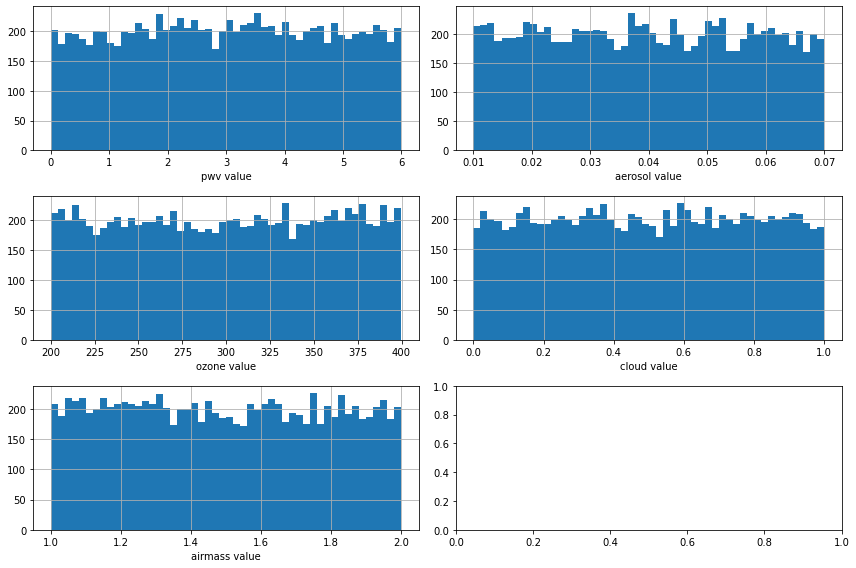

In [5]:
fig_rows = 3
fig_cols = 2
fig, axs = plt.subplots(fig_rows, fig_cols, figsize=(12,8))
i = 0
for row in range(fig_rows):
    for col in range(fig_cols):
        if i<len(atm_params):
            atm_param_ = atm_params[i]
            i += 1
            
            axs[row,col].hist(sim_dict[atm_param_],bins=50)
            axs[row,col].set_xlabel('{0} value'.format(atm_param_))
            axs[row,col].grid()
        
plt.tight_layout()

# Test fixing the parameters 

In [6]:
#aer0 = np.mean(sim_dict['aerosol'])
#oz0 = np.mean(sim_dict['ozone'])
aer0 = dist_params['aerosol']['loc']
oz0 = dist_params['ozone']['loc']
pwv0 = dist_params['pwv']['loc']

#cloud0 = np.mean(sim_dict['cloud'])
#am0 = np.mean(sim_dict['airmass'])
am0 = 1.99
pressure = 0.0
cloud0 = 0.0

print('Aerosols - PWV - Ozone - Clouds - Airmass - Pressure')
print(aer0,'-',pwv0,'-',oz0,'-',cloud0,'-',am0,'-',pressure)

Aerosols - PWV - Ozone - Clouds - Airmass - Pressure
0.04 - 3.0 - 300 - 0.0 - 1.99 - 0.0


# Simulate atm transparencies from the PWV simulated values 

In [7]:
sys.path.append('libradtran')
print(sys.path)

['/home/martin/auxtel_lsst/github/my_photomCorrectAuxtel/AuxTel_atm_photo_corr', '/home/martin/anaconda3/envs/python38/lib/python38.zip', '/home/martin/anaconda3/envs/python38/lib/python3.8', '/home/martin/anaconda3/envs/python38/lib/python3.8/lib-dynload', '', '/home/martin/anaconda3/envs/python38/lib/python3.8/site-packages', '/home/martin/anaconda3/envs/python38/lib/python3.8/site-packages/locket-0.2.1-py3.8.egg', 'libradtran']


In [8]:
import libsimulateVisible

libradtranpath= /home/martin/auxtel_lsst/External/libRadtran/


In [9]:
#Example with one PWV value, to see that everything works 
path,thefile=libsimulateVisible.ProcessSimulationaer(am0,pwv0,oz0,aer0,pressure,prof_str='us',proc_str='as',cloudext=cloud0)

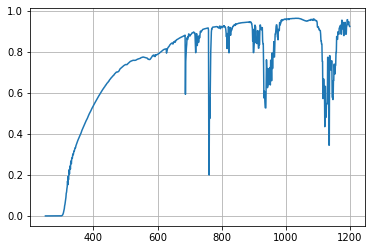

In [10]:
transp0 = np.loadtxt(os.path.join(path,thefile))
l = transp0[:,0]
t = transp0[:,1]

plt.plot(l,t)
plt.grid()

In [11]:
nwl = len(l)
print(nwl)

951


# Check that the wavelenghts are the same 

In [12]:
path2,thefile2=libsimulateVisible.ProcessSimulationaer(am0,pwv0,oz0,aer0,pressure,prof_str='us',proc_str='as',cloudext=0)
transp02 = np.loadtxt(os.path.join(path2,thefile2))
wl = transp02[:,0]
print((wl==l).all())
wl_ref = wl

True


# Simulate atm transparencies for all simulated values of the selected parameter (we will vary only one parameter) 

In [13]:
variable_param = 'pwv'

In [14]:
fixed_params = {}
for param in atm_params:
    if param!=variable_param:
        if param!='airmass' and param!='cloud':
            #fixed_params[param] = np.mean(sim_dict[param])
            fixed_params[param] = dist_params[param]['loc']
        if param=='airmass':
            fixed_params[param] = am0
        elif param=='cloud':
            fixed_params[param] = cloud0
        else:
            #fixed_params[param] = np.mean(sim_dict[param])
            fixed_params[param] = dist_params[param]['loc']


In [15]:
n_transp = 25

In [16]:
fixed_params

{'aerosol': 0.04, 'ozone': 300, 'cloud': 0.0, 'airmass': 1.99}

In [17]:
if variable_param!='airmass':
    var_param = np.linspace(dist_params[variable_param]['loc']-dist_params[variable_param]['scale'],dist_params[variable_param]['loc']+dist_params[variable_param]['scale'],n_transp)
else:
    var_param = np.linspace(min_airmass,max_airmass,n_transp)

In [18]:
var_param

array([0.  , 0.25, 0.5 , 0.75, 1.  , 1.25, 1.5 , 1.75, 2.  , 2.25, 2.5 ,
       2.75, 3.  , 3.25, 3.5 , 3.75, 4.  , 4.25, 4.5 , 4.75, 5.  , 5.25,
       5.5 , 5.75, 6.  ])

In [19]:
dataout = np.zeros((n_transp+1,nwl+nparams))
dataout[0,nparams:] = wl_ref
for isim in range(1,n_transp+1):
    print(isim)
    for param in atm_params:
        if param != variable_param:
            dataout[isim,index_params[param]] = fixed_params[param]
        else:
            #dataout[isim,index_params[param]] = sim_dict[param][isim]
            dataout[isim,index_params[param]] = var_param[isim-1]
            
    airmass_ = dataout[isim,index_params['airmass']]
    pwv_ = dataout[isim,index_params['pwv']]
    ozone_ = dataout[isim,index_params['ozone']]
    aerosol_ = dataout[isim,index_params['aerosol']]
    cloud_ = dataout[isim,index_params['cloud']]
    #Run libradtran 
    path,thefile=libsimulateVisible.ProcessSimulationaer(airmass_,pwv_,ozone_,aerosol_,pressure,prof_str='us',proc_str='as',cloudext=cloud_)
    transp_file = np.loadtxt(os.path.join(path,thefile))
    
    t = transp_file[:,1]
    dataout[isim,nparams:] = t
    
# Reference atmosphere 
dataout_ref = np.zeros((2,nwl+nparams))
dataout_ref[0,nparams:] = wl_ref
for param in atm_params:
    if param!=variable_param:
        dataout_ref[1,index_params[param]] = fixed_params[param]
    else:
        if param=='airmass':
            dataout_ref[1,index_params[param]] = am0
        elif param=='cloud':
            dataout_ref[1,index_params[param]] = cloud0
        else:
            dataout_ref[1,index_params[param]] = dist_params[param]['loc']
    
airmass_ = dataout_ref[1,index_params['airmass']]
pwv_ = dataout_ref[1,index_params['pwv']]
ozone_ = dataout_ref[1,index_params['ozone']]
aerosol_ = dataout_ref[1,index_params['aerosol']]
cloud_ = dataout_ref[1,index_params['cloud']]

path_ref,thefile_ref = libsimulateVisible.ProcessSimulationaer(airmass_,pwv_,ozone_,aerosol_,pressure,prof_str='us',proc_str='as',cloudext=cloud_)
transp_file_ref = np.loadtxt(os.path.join(path_ref,thefile_ref))

t_ref = transp_file_ref[:,1]
dataout_ref[1,nparams:] = t_ref

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25


In [20]:
hdr = fits.Header()
hdr['NTRANSP']=n_transp
#hdr['ID_NUM']=idx_out_num
hdr['ID_AM']=index_params['airmass']
hdr['ID_VAOD']=index_params['aerosol']
hdr['ID_PWV']=index_params['pwv']
hdr['ID_O3']=index_params['ozone']
hdr['ID_CLD']=index_params['cloud']
hdr['ID_RES']=nparams

output_dir = './simulated_transparencies'
if os.path.exists(output_dir) == False:
    os.mkdir(output_dir)
if variable_param=='airmass' or variable_param=='cloud':
    output_file = 'simulated_transparencies_varying_{0}.fits'.format(variable_param)
else:
    output_file = 'simulated_transparencies_varying_{0}_airmass_{1}_cloud_{2}.fits'.format(variable_param,am0,cloud0)

output_fullfilename = os.path.join(output_dir,output_file)

hdu = fits.PrimaryHDU(dataout,header=hdr)
hdu.writeto(output_fullfilename,overwrite=True)

In [21]:
hdr = fits.Header()
hdr['NTRANSP']=n_transp
#hdr['ID_NUM']=idx_out_num
hdr['ID_AM']=index_params['airmass']
hdr['ID_VAOD']=index_params['aerosol']
hdr['ID_PWV']=index_params['pwv']
hdr['ID_O3']=index_params['ozone']
hdr['ID_CLD']=index_params['cloud']
hdr['ID_RES']=nparams

output_dir = './simulated_transparencies'
if os.path.exists(output_dir) == False:
    os.mkdir(output_dir)
if variable_param=='airmass' or variable_param=='cloud':
    output_file = 'simulated_transparencies_varying_{0}_ref.fits'.format(variable_param)
else:
    output_file = 'simulated_transparencies_varying_{0}_airmass_{1}_cloud_{2}_ref.fits'.format(variable_param,am0,cloud0)

output_fullfilename_ref = os.path.join(output_dir,output_file)

hdu = fits.PrimaryHDU(dataout_ref,header=hdr)
hdu.writeto(output_fullfilename_ref,overwrite=True)